# Analysis of Results

This notebook creates the tables and figures used in the paper. 
To reproduce the contents of this notebook, you need to download 
- the models' ensembled predictions (either from [Zenodo (models)](https://doi.org/10.5281/zenodo.4071886) or, apart from NWM, created yourself) into the folder `BASE_DIR`
- the [CAMELS dataset](https://ral.ucar.edu/solutions/products/camels) into the folder `DATA_DIR` (more precisely, for this notebook, only the static attributes in `DATA_DIR/camels_attributes_v2.0` are required)

`README.md` contains information on where to obtain the required data.

In [1]:
import pickle
from collections import defaultdict
from itertools import product
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from scipy.stats import wilcoxon, pearsonr
from tqdm.notebook import tqdm

from neuralhydrology.data.utils import load_camels_us_forcings, load_hourly_us_netcdf, load_camels_us_attributes
from neuralhydrology.evaluation.metrics import calculate_metrics
from neuralhydrology.evaluation.signatures import calculate_signatures, get_available_signatures

rc('font',**{'family':'serif', 'size': 13})
rc('text', usetex=True)

DATA_DIR = Path('/home/mgauch/mts-lstm/data/datadir/CAMELS_US')
BASE_DIR = Path('/home/mgauch/mts-lstm/results')
MODELS = ['naive-daily', 'naive-hourly', 'MTS-LSTM', 'sMTS-LSTM', 'NWM']

# If set to false, will aggregate NWM predictions, calculate metrics for daily and hourly NWM predictions,
# and calculate signatures for all models. The results will be written to BASE_DIR.
# If True, will look in BASE_DIR for files `nwm_results.p` and `signatures.p` and load the data from there.
# You can either run the notebook once with PRECALCULATED_DATA = False (will take some time) or download the
# pre-calculated data from zenodo (https://doi.org/10.5281/zenodo.4071886).
PRECALCULATED_DATA = True

COLORS = ['#004C71', '#00BABF', '#FFA741', '#CF5000']

## Preparation
### Load predictions and metrics for each model ensemble

In [2]:
# Baselines: naive LSTMs
dailylstm_ensemble = pickle.load(open(BASE_DIR / 'ensemble_dailylstm.p', 'rb'))
hourlylstm_ensemble = pickle.load(open(BASE_DIR / 'ensemble_hourlylstm.p', 'rb'))

# MTS-LSTM without and with per-frequency input variables
mtslstm_ensemble = pickle.load(open(BASE_DIR / 'ensemble_mtslstm.p', 'rb'))
mtslstm_multiforcing_ensemble = pickle.load(open(BASE_DIR / 'ensemble_mtslstm_multiforcing_validation.p', 'rb'))

# sMTS-LSTM with and without cross-frequency regularization
smtslstm_ensemble = pickle.load(open(BASE_DIR / 'ensemble_smtslstm.p', 'rb'))
smtslstm_noregularization_ensemble = pickle.load(open(BASE_DIR / 'ensemble_smtslstm_noregularization.p', 'rb'))

# predicting more than daily and hourly
multifreq_mtslstm_ensemble = pickle.load(open(BASE_DIR / 'ensemble_mtslstm_136H1D.p', 'rb'))

BASINS = list(mtslstm_ensemble.keys())
metrics = ['NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-NSE', 'FHV', 'FMS', 'FLV', 'Peak-Timing']

### Calculate or load metrics for NWM

In [3]:
if not PRECALCULATED_DATA:
    nwm = pickle.load(open(BASE_DIR / 'nwm_chrt_v2_1h.p', 'rb'))
    nwm_results = defaultdict(lambda: defaultdict(dict))
    for basin in tqdm(BASINS):
        nwm_pred = nwm[basin][['streamflow']].rename({'streamflow': 'qobs_mm_per_hour_sim'}, axis=1)
        nwm_pred.index = nwm_pred.index.rename('datetime')
        # convert to mm/h
        _, area = load_camels_us_forcings(DATA_DIR, basin, 'daymet')
        nwm_pred['qobs_mm_per_hour_sim'] = 10**9 * nwm_pred['qobs_mm_per_hour_sim'] * 3600 / (area * 10**6)
        nwm_pred = nwm_pred.resample('1H').first()  # fill missing hours with NaN
        
        # in the experiment with >2 frequencies, we only predict the last 18 hours of each day, so to have an equal
        # comparison, we need to calculate NWM results over the last 18 hours only, too.
        # For all other experiments though, we use the full day.
        multifreq_nwm_pred = nwm_pred[nwm_pred.index.hour >= 6]
        
        # subset to test period, use observations from one of the other models' dfs
        for freq_key in ['1H', '3H', '6H', '1D', '1H_mf']:  # 1H_mf stands for the experiment with >2 frequencies.
            freq = freq_key.replace('_mf', '')
            if freq == '1H':
                nwm_freq = nwm_pred
            elif freq_key == '1H_mf':
                nwm_freq = multifreq_nwm_pred
            else:
                nwm_freq = nwm_pred.resample(freq).mean()
            nwm_results[basin][freq_key]['xr'] = xr.Dataset.from_dataframe(nwm_freq.loc['2008-10-01':'2018-09-30 23:59:59'])
            
            # for the experiment with >2 frequencies, use the mf_multifreq_ensemble results, else the normal results.
            if freq_key in ['1H_mf', '3H', '6H']:
                nwm_results[basin][freq_key]['xr']['qobs_mm_per_hour_obs'] = \
                    multifreq_multifreqlstm_ensemble[basin][freq]['xr']['qobs_mm_per_hour_obs']
            else:
                nwm_results[basin][freq_key]['xr']['qobs_mm_per_hour_obs'] = \
                    multifreqlstm_ensemble[basin][freq]['xr']['qobs_mm_per_hour_obs']

            # add metrics
            freq_metrics = calculate_metrics(nwm_results[basin][freq_key]['xr']['qobs_mm_per_hour_obs'], 
                                             nwm_results[basin][freq_key]['xr']['qobs_mm_per_hour_sim'],
                                             metrics=metrics, resolution=freq)

            for metric in metrics:
                nwm_results[basin][freq_key][f'{metric}_{freq}'] = freq_metrics[metric]

        nwm_results[basin] = dict(nwm_results[basin])
    pickle.dump(dict(nwm_results), (BASE_DIR / 'nwm_results.p').open('wb'))
    
nwm_results = pickle.load((BASE_DIR / 'nwm_results.p').open('rb'))

### Calculate or load signatures

In [4]:
if not PRECALCULATED_DATA:
    all_signatures = get_available_signatures()
    all_signatures.remove('baseflow_index')  # we'll calculate that separately
    precip = load_hourly_us_netcdf(DATA_DIR, 'nldas_hourly')['total_precipitation'] \
        .sel(date=slice('2008-10-01', '2018-09-30 23:59:59')).rename({'date': 'datetime'})
    signatures = defaultdict(lambda: defaultdict(dict))
    for basin in tqdm(BASINS):
        for freq in ['1H', '1D']:
            # resample precipitation
            if freq == '1D':
                f_precip = xr.DataArray(precip.sel(basin=basin).to_series().resample('1D').sum())
            else:
                f_precip = precip.sel(basin=basin)

            # get obs signatures for one of the models (doesn't matter which one)
            qobs = mtslstm_ensemble[basin][freq]['xr']['qobs_mm_per_hour_obs'] * (24 if freq == '1D' else 1)
            signatures['obs'][basin][freq] = calculate_signatures(qobs, all_signatures + ['baseflow_index'],
                                                                  datetime_coord='datetime', prcp=f_precip)

            # get sim signatures
            for model_name, model_results in zip(MODELS + ['sMTS-LSTM-no-reg'], 
                                                 [dailylstm_ensemble, hourlylstm_ensemble, mtslstm_ensemble, 
                                                  smtslstm_ensemble, nwm_results, 
                                                  smtslstm_noregularization_ensemble]):
                if ('daily' in model_name and freq == '1H') or ('hourly' in model_name and freq == '1D'):
                    continue
                qsim = model_results[basin][freq]['xr']['qobs_mm_per_hour_sim'] * (24 if freq == '1D' else 1)
                qsim = xr.where(qsim < 0, 0, qsim)  # clip predictions to 0
                signatures[model_name][basin][freq] = \
                    calculate_signatures(qsim, all_signatures, datetime_coord='datetime', prcp=f_precip)
                
                # for baseflow index calculation, mask the array in the same places where obs has NaNs.
                masked_sim = qsim.copy()
                masked_sim[qobs.isnull()] = np.nan
                signatures[model_name][basin][freq]['baseflow_index'] = \
                    calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']

    pickle.dump({k: dict(v) for k, v in signatures.items()}, (BASE_DIR / 'signatures.p').open('wb'))

signatures = pickle.load((BASE_DIR / 'signatures.p').open('rb'))

### Define some utility functions

In [5]:
def ecdf(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Calculates empirical cumulative density function. """
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys

def get_inconsistency(results: dict, daily_results: dict = None) -> Dict[str, float]:
    """
    If daily_results is provided, calculates inconsistency between day-aggregated
    hourly results from `results` and daily results.
    If daily_results is None, calculates inconsistency within `results`.
    """
    inconsistency = {}
    for basin, basin_results in results.items():
        hourly_results = basin_results['1H']['xr']['qobs_mm_per_hour_sim']
        hourly_results = hourly_results.to_series()
        daily_aggregated = hourly_results.resample('1D').mean()
        if daily_results is None:
            basin_daily_results = basin_results['1D']['xr']['qobs_mm_per_hour_sim'].to_series()
        else:
            basin_daily_results = daily_results[basin]['1D']['xr']['qobs_mm_per_hour_sim'].to_series()
        # convert to mm/d and calculate inconsistency
        daily_aggregated = daily_aggregated * 24
        basin_daily_results = basin_daily_results * 24
        inconsistency[basin] = np.sqrt(np.mean(np.square(daily_aggregated - basin_daily_results)))
    
    return inconsistency
    
def cohens_d(list_one: List[float], list_two: List[float]) -> float:
    """Calculate Cohen's d (effect size). """
    s = np.sqrt(((len(list_one) - 1) * np.var(list_one) + (len(list_two) - 1) * np.var(list_two)) /
                (len(list_one) + len(list_two) - 2))
    d = (np.abs(np.mean(list_one) - np.mean(list_two))) / s
    return d

def wilcoxon_cohen(list_one: List[float], list_two: List[float]) -> Tuple[float, float]:
    """Calculate Wilcoxon p-value and Cohen's d effect size. """
    _, p = wilcoxon(list_one, list_two)
    d = cohens_d(list_one, list_two)
    return p, d

def dict_to_df(model: str, results: dict, freqs: List[str]) -> pd.DataFrame:
    """Convert a nested dict into a MultiIndex DataFrame. """
    results = results.copy()
    for basin in results.keys():
        for freq in freqs:
            keys = list(results[basin][freq].keys())
            for key in keys:
                results[basin][freq][key.replace(f'_{freq}', '')] = results[basin][freq].pop(key)
    df = pd.DataFrame.from_dict({(model, basin, freq): results[basin][freq]
                                 for basin in results.keys() 
                                 for freq in freqs},
                                orient='index').drop(columns='xr')
    df = df.swaplevel(1, 2, axis=0)
    df.index.rename(['model', 'freq', 'basin'], inplace=True)
    return df

def significance(results_df: pd.DataFrame, reference_model: str, freq: str, metric: str) -> Tuple[dict, dict]:
    """Calculate Wilcoxon p-value + Cohen's d for each model in comparison to the reference model w.r.t. the metric. """
    reference_metrics = results_df.loc[(reference_model, freq, slice(None)), metric]
    grouped = results_df.loc(axis=0)[:, freq, :].groupby('model')
    p, d = {}, {}
    for model in grouped.groups:
        if model == reference_model:
            p[model], d[model] = np.nan, np.nan
            continue
        
        # make sure reference and group have same order
        group_metrics = grouped.get_group(model)[metric]
        ref_and_group = pd.merge(reference_metrics, group_metrics, on='basin')

        # perform significance test and get effect size
        p[model], d[model] = wilcoxon_cohen(ref_and_group[f'{metric}_x'], ref_and_group[f'{metric}_y'])
        
    return p, d

def highlight_nonsig(s: pd.Series, freq: str, direction: str, 
                     res_df: pd.DataFrame, metric: str, p_sig: float = 0.001) -> List[str]:
    """Highlight entries that are not significantly worse than the best entry. """
    if direction == 'larger':
        best_model = s.idxmax()
    elif direction == 'diverging':
        best_model = s.abs().idxmin()
    elif direction == 'lower':
        best_model = s.idxmin()
    else:
        raise ValueError(f'Cannot find best value based on unknown direction {direction}.')

    p, d = significance(res_df, best_model, freq, metric)
    not_sig = [(p[r] >= p_sig) or (r == best_model) for r in s.index.get_level_values('model')]
    return ['font-weight: bold' if v else '' for v in not_sig]

## Benchmarking: compare metrics and signatures

In [6]:
# create a DataFrame with metrics for each basin and frequency
results_df = pd.concat([dict_to_df(model_name, model, ['1D', '1H']) 
                        for model_name, model in zip(MODELS,
                                                     [dailylstm_ensemble, hourlylstm_ensemble, mtslstm_ensemble, 
                                                      smtslstm_ensemble, nwm_results])]).sort_index()

# do the same for the signatures
sig_df = pd.DataFrame.from_dict({(model, freq, basin): signatures[model][basin][freq]
                                 for model in signatures.keys()
                                 for basin in signatures[model].keys() 
                                 for freq in signatures[model][basin].keys()},
                                orient='index').sort_index()
sig_df.index.rename(['model', 'freq', 'basin'], inplace=True)

In [7]:
# compare metrics
medians = results_df.groupby(['model', 'freq']).median()
medians['NSE_mean'] = results_df['NSE'].groupby(['model', 'freq']).mean()
medians['NSE<0'] = results_df['NSE'].groupby(['model', 'freq']).apply(lambda c: (c<0).sum())
for freq in ['1D', '1H']:
    print('Metrics', freq)
    f_medians = medians.loc(axis=0)[:,freq].sort_values('NSE', ascending=False)
    f_medians.index = f_medians.index.droplevel(1)

    display(f_medians.style.format('{:.3f}') \
        .apply(lambda s: highlight_nonsig(s, freq, 'larger', results_df, s.name),
               subset=['NSE', 'KGE', 'Alpha-NSE', 'Pearson-r']) \
        .apply(lambda s: highlight_nonsig(s, freq, 'diverging', results_df, s.name),
               subset=['Beta-NSE', 'FHV', 'FMS', 'FLV']) \
        .apply(lambda s: highlight_nonsig(s, freq, 'lower', results_df, s.name),
               subset=['MSE', 'RMSE', 'Peak-Timing']))
    
# compare signatures
for freq in ['1D', '1H']:
    print('Signatures', freq)
    sig_corr = pd.DataFrame(index=MODELS, columns=sig_df.columns, dtype=float)
    sig_corr.index.rename('model', inplace=True)
    for model in sig_corr.index:
        if ('daily' in model and freq == '1H') or ('hourly' in model and freq == '1D'):
                sig_corr = sig_corr.drop(model, axis=0)
                continue
        for sig in sig_corr.columns:
            obs_sig = sig_df.loc(axis=0)['obs', freq][sig].sort_index()
            sim_sig = sig_df.loc(axis=0)[model, freq][sig].reindex(obs_sig.index)
            mask = ~(pd.isna(obs_sig) | pd.isna(sim_sig))
            if mask.sum() == 0:
                continue
            sig_corr.loc[model, sig] = pearsonr(obs_sig[mask].values, sim_sig[mask].values)[0]

    display(sig_corr.reindex(sorted(sig_corr.index, key=lambda x: x.lower())) \
            .style.format('{:.3f}') \
            .apply(lambda s: highlight_nonsig(s, freq, 'larger', sig_df, s.name)))

Metrics 1D


,NSE,MSE,RMSE,KGE,Alpha-NSE,Pearson-r,Beta-NSE,FHV,FMS,FLV,Peak-Timing,NSE_mean,NSE<0
model,,,,,,,,,,,,,
sMTS-LSTM,0.762,0.002,0.048,0.727,0.819,0.891,-0.055,-17.656,-9.025,9.617,0.306,0.662,10.000
naive-daily,0.755,0.002,0.048,0.760,0.873,0.885,-0.042,-13.336,-10.273,12.195,0.310,0.631,18.000
MTS-LSTM,0.750,0.002,0.049,0.714,0.813,0.882,-0.043,-17.834,-13.421,9.730,0.333,0.602,12.000
NWM,0.636,0.004,0.059,0.666,0.847,0.821,-0.038,-15.053,-5.099,0.775,0.474,0.471,37.000


Metrics 1H


,NSE,MSE,RMSE,KGE,Alpha-NSE,Pearson-r,Beta-NSE,FHV,FMS,FLV,Peak-Timing,NSE_mean,NSE<0
model,,,,,,,,,,,,,
sMTS-LSTM,0.752,0.003,0.054,0.731,0.828,0.885,-0.045,-16.296,-9.274,-35.214,3.540,0.652,13.000
naive-hourly,0.751,0.003,0.054,0.739,0.837,0.882,-0.039,-14.467,-8.896,-35.097,3.754,0.644,13.000
MTS-LSTM,0.748,0.003,0.055,0.726,0.825,0.882,-0.039,-16.115,-12.772,-35.354,3.757,0.620,17.000
NWM,0.559,0.005,0.071,0.638,0.846,0.779,-0.034,-14.174,-5.264,6.315,5.957,0.364,46.000


Signatures 1D


/home/mgauch/miniconda3/envs/pytorch/lib/python3.7/site-packages/scipy/stats/morestats.py:2975: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r)
/home/mgauch/miniconda3/envs/pytorch/lib/python3.7/site-packages/scipy/stats/morestats.py:2976: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r)


,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,q95,q5,q_mean,hfd_mean,slope_fdc,stream_elas,runoff_ratio,baseflow_index
model,,,,,,,,,,,,,
MTS-LSTM,0.486,0.463,0.657,0.285,0.286,0.978,0.945,0.984,0.943,0.430,0.560,0.957,0.818
naive-daily,0.598,0.491,0.774,0.280,0.409,0.980,0.979,0.986,0.945,0.679,0.615,0.962,0.904
NWM,0.730,0.457,0.796,0.303,0.502,0.956,0.928,0.972,0.908,0.663,0.537,0.924,0.865
sMTS-LSTM,0.599,0.512,0.774,0.316,0.392,0.979,0.970,0.985,0.930,0.556,0.601,0.960,0.897


Signatures 1H


,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,q95,q5,q_mean,hfd_mean,slope_fdc,stream_elas,runoff_ratio,baseflow_index
model,,,,,,,,,,,,,
MTS-LSTM,0.537,0.416,0.697,0.274,0.401,0.979,0.955,0.983,0.948,0.633,0.563,0.954,0.908
naive-hourly,0.619,0.471,0.782,0.307,0.493,0.979,0.964,0.983,0.941,0.647,0.626,0.952,0.932
NWM,0.719,0.316,0.789,0.160,0.505,0.956,0.927,0.970,0.907,0.712,0.588,0.918,0.869
sMTS-LSTM,0.588,0.433,0.764,0.309,0.363,0.980,0.968,0.984,0.944,0.635,0.601,0.955,0.935


In [8]:
p, d = significance(results_df, 'sMTS-LSTM', '1D', 'NSE')
print(f'1D: Significance sMTS-LSTM vs. naive-daily: {p["naive-daily"]:.3e}')
print(f'1D: Significance sMTS-LSTM vs. MTS-LSTM: {p["MTS-LSTM"]:.3e}')
p, d = significance(results_df, 'sMTS-LSTM', '1H', 'NSE')
print(f'1H: Significance sMTS-LSTM vs. naive-hourly: {p["naive-hourly"]:.3e}')
print(f'1H: Significance sMTS-LSTM vs. MTS-LSTM: {p["MTS-LSTM"]:.3e}')

1D: Significance sMTS-LSTM vs. naive-daily: 8.669e-02
1D: Significance sMTS-LSTM vs. MTS-LSTM: 3.248e-29
1H: Significance sMTS-LSTM vs. naive-hourly: 2.688e-03
1H: Significance sMTS-LSTM vs. MTS-LSTM: 3.726e-19


## Cross-frequency consistency
Mean squared difference between daily and day-aggregated hourly predictions

In [9]:
# calculate inconsistency
mtslstm_inconsistency = get_inconsistency(mtslstm_ensemble)
smtslstm_inconsistency = get_inconsistency(smtslstm_ensemble)
smtslstm_noreg_inconsistency = get_inconsistency(smtslstm_noregularization_ensemble)
naivelstm_inconsistency = get_inconsistency(hourlylstm_ensemble, dailylstm_ensemble)

inconsistency = pd.DataFrame({'MTS-LSTM': mtslstm_inconsistency,
                              'sMTS-LSTM': smtslstm_inconsistency,
                              'sMTS-LSTM (no regularization)': smtslstm_noreg_inconsistency,
                              'naive': naivelstm_inconsistency}).T.agg(['median', 'max'], axis=1).sort_values('median')
inconsistency['p'] = np.nan
inconsistency['d'] = np.nan

# calculate significance and effect size
inconsistency.loc['MTS-LSTM', ['p', 'd']] = wilcoxon_cohen(list(smtslstm_inconsistency.values()), 
                                                           list(mtslstm_inconsistency.values()))
inconsistency.loc['naive', ['p', 'd']] = wilcoxon_cohen(list(smtslstm_inconsistency.values()), 
                                                        list(naivelstm_inconsistency.values()))
inconsistency.loc['sMTS-LSTM (no regularization)', ['p', 'd']] = wilcoxon_cohen(list(smtslstm_inconsistency.values()), 
                                                                                list(smtslstm_noreg_inconsistency.values()))
inconsistency.loc[['sMTS-LSTM', 'sMTS-LSTM (no regularization)','naive']].style.format('{:.2e}', subset=['p']) \
    .format('{:.5f}', subset=['median', 'max']) \
    .format('{:.3f}', subset=['d'])

,median,max,p,d
sMTS-LSTM,0.37591,1.66999,nan,nan
sMTS-LSTM (no regularization),0.39832,2.17620,1.49e-25,0.091
naive,0.48984,2.22558,7.09e-72,0.389


## Metric CDF

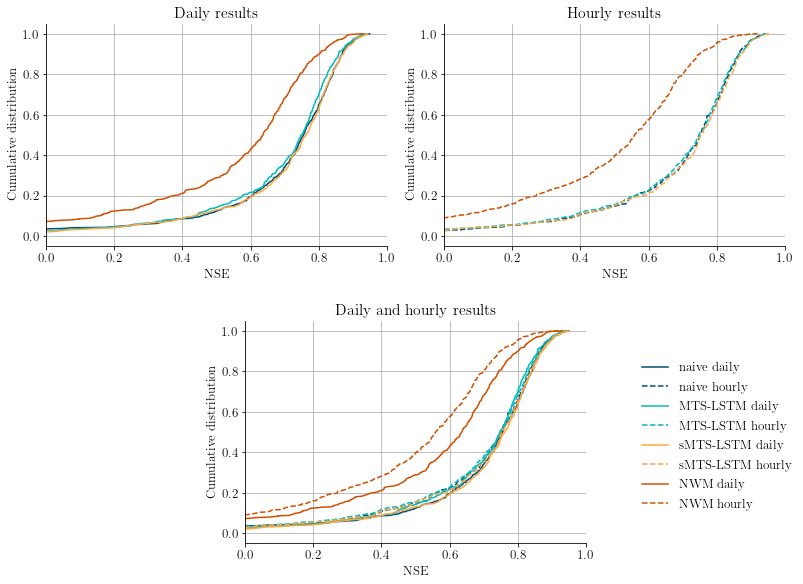

In [10]:
metric = 'NSE'
model_name = {'MTS-LSTM': 'MTS-LSTM', 'sMTS-LSTM': 'sMTS-LSTM', 'NWM': 'NWM',
              'naive-daily': 'naive', 'naive-hourly': 'naive'}
freq_name = {'1D': 'daily', '1H': 'hourly'}
colors = dict(zip(['naive', 'MTS-LSTM', 'sMTS-LSTM', 'NWM'], COLORS))

fig = plt.figure(constrained_layout=True, figsize=(11,8))
gs = GridSpec(3, 4, figure=fig, height_ratios=[0.495, 0.01, 0.495])
ax_all = fig.add_subplot(gs[2, 1:3])
ax_d = fig.add_subplot(gs[0, :2])
ax_h = fig.add_subplot(gs[0, 2:])
    
def plot(ax, models, freqs):
    for model in models:
        for freq in freqs:
            ls = {'1D': '-' , '1H': '--'}[freq]
            if ('daily' in model and freq == '1H') or ('hourly' in model and freq == '1D'):
                continue
            vals = results_df.loc[model, freq][metric]
            bins, cdf = ecdf(vals)
            ax.plot(bins, cdf, label=f'{model_name[model]} {freq_name[freq]}',
                    color=colors[model_name[model]], ls=ls)
            if freqs == ['1D']:
                title = 'Daily results' 
            elif freqs == ['1H']:
                title = 'Hourly results'
            else:
                title = 'Daily and hourly results'
            ax.set_title(title)

    ax.set_xlim(0, 1)
    ax.grid()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(metric)
    ax.set_ylabel('Cumulative distribution')

for ax, freqs, models in zip([ax_all, ax_d, ax_h], [['1D', '1H'], ['1D'], ['1H']],
                      [MODELS, ['naive-daily', 'MTS-LSTM', 'sMTS-LSTM', 'NWM'],
                       ['naive-hourly', 'MTS-LSTM', 'sMTS-LSTM', 'NWM']]):
    plot(ax, models, freqs)

handles, labels = ax_all.get_legend_handles_labels()
_ = fig.legend(handles, labels, frameon=False, loc='lower center', ncol=1,
               bbox_to_anchor=(0.4,0.1,1,1), bbox_transform=plt.gcf().transFigure)
plt.savefig(BASE_DIR / f'{metric}-cdf.pdf', bbox_inches='tight')

## Per-timescale input variables

In [11]:
# validation results for single-forcings models
val_mtslstm_ensemble = pickle.load(open(BASE_DIR / 'ensemble_mtslstm_validation.p', 'rb'))
val_smtslstm_ensemble = pickle.load(open(BASE_DIR / 'ensemble_smtslstm_validation.p', 'rb'))

# validation results for multi-forcing MTS-LSTM with Daymet+Maurer as daily and NLDAS as hourly inputs
val_mtslstm_multiforcing_ensemble = pickle.load(open(BASE_DIR / 'ensemble_mtslstm_multiforcing_validation.p', 'rb'))

# validation results for multi-forcing multifrequency LSTM with Daymet+Maurer as daily and NLDAS+Daymet+Maurer as hourly inputs
val_mtslstm_multiforcing_dailyhourly_ensemble = pickle.load(open(BASE_DIR / 'ensemble_mtslstm_multiforcing_dailyhourly_validation.p', 'rb'))

# create a dataframe with val metrics for each basin and frequency
val_results_df = pd.concat([dict_to_df(model_name, model, ['1D', '1H'])
                        for model_name, model in zip(['MTS-LSTM', 'sMTS-LSTM', 'MTS-LSTM Multiforcing 1', 'MTS-LSTM Multiforcing 2'],
                                                     [val_mtslstm_ensemble, val_smtslstm_ensemble,
                                                      val_mtslstm_multiforcing_ensemble,
                                                      val_mtslstm_multiforcing_dailyhourly_ensemble])]).sort_index()

# compare values
val_medians = val_results_df.groupby(['model', 'freq']).median()
val_medians['NSE_mean'] = val_results_df['NSE'].groupby(['model', 'freq']).mean()
val_medians['NSE<0'] = val_results_df['NSE'].groupby(['model', 'freq']).apply(lambda c: (c<0).sum())
for freq in ['1D', '1H']:
    print(freq)
    f_medians = val_medians.loc(axis=0)[:,freq].sort_values('NSE', ascending=False)
    f_medians.index = f_medians.index.droplevel(1)
    display(f_medians.loc[['MTS-LSTM Multiforcing 2','MTS-LSTM Multiforcing 1', 'sMTS-LSTM', 'MTS-LSTM']].style.format('{:.3f}') \
        .apply(lambda s: highlight_nonsig(s, freq, 'larger', val_results_df, s.name),
               subset=['NSE', 'KGE', 'Alpha-NSE', 'Pearson-r']) \
        .apply(lambda s: highlight_nonsig(s, freq, 'diverging', val_results_df, s.name),
               subset=['Beta-NSE', 'FHV', 'FMS', 'FLV']) \
        .apply(lambda s: highlight_nonsig(s, freq, 'lower', val_results_df, s.name),
               subset=['MSE', 'RMSE', 'Peak-Timing']))

1D


/home/mgauch/miniconda3/envs/pytorch/lib/python3.7/site-packages/scipy/stats/morestats.py:2975: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r)
/home/mgauch/miniconda3/envs/pytorch/lib/python3.7/site-packages/scipy/stats/morestats.py:2976: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r)


,NSE,MSE,RMSE,KGE,Alpha-NSE,Pearson-r,Beta-NSE,FHV,FMS,FLV,Peak-Timing,NSE_mean,NSE<0
model,,,,,,,,,,,,,
MTS-LSTM Multiforcing 2,0.811,0.002,0.040,0.782,0.879,0.912,0.014,-10.993,-14.179,14.034,0.250,0.661,18.000
MTS-LSTM Multiforcing 1,0.805,0.002,0.039,0.777,0.874,0.911,0.018,-11.870,-14.388,12.850,0.273,0.663,16.000
sMTS-LSTM,0.785,0.002,0.043,0.779,0.865,0.902,-0.014,-13.562,-9.336,9.931,0.286,0.669,13.000
MTS-LSTM,0.766,0.002,0.042,0.760,0.853,0.895,-0.007,-14.042,-13.085,14.486,0.308,0.603,15.000


1H


,NSE,MSE,RMSE,KGE,Alpha-NSE,Pearson-r,Beta-NSE,FHV,FMS,FLV,Peak-Timing,NSE_mean,NSE<0
model,,,,,,,,,,,,,
MTS-LSTM Multiforcing 2,0.812,0.002,0.045,0.801,0.905,0.911,0.014,-8.086,-13.114,-26.969,3.846,0.679,17.000
MTS-LSTM Multiforcing 1,0.781,0.002,0.049,0.788,0.888,0.898,0.007,-9.854,-13.437,-27.567,3.711,0.630,21.000
sMTS-LSTM,0.783,0.002,0.048,0.779,0.886,0.901,-0.006,-10.557,-10.606,-34.003,3.571,0.657,20.000
MTS-LSTM,0.776,0.002,0.049,0.768,0.874,0.895,-0.002,-11.232,-12.996,-62.439,3.800,0.615,20.000


## Spatial distribution of metrics

/home/mgauch/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/mgauch/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/mgauch/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


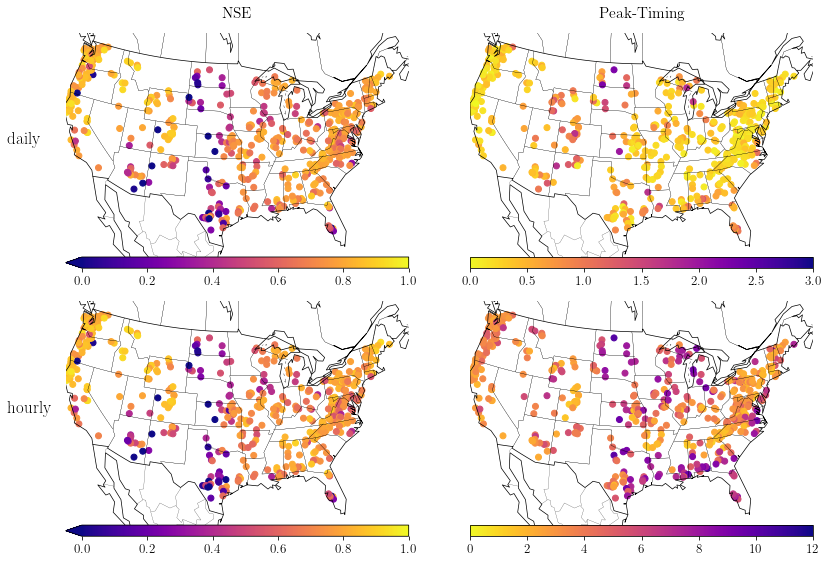

In [12]:
model = 'sMTS-LSTM'
freqs = ['1D', '1H']
metrics = ['NSE', 'Peak-Timing']
v = {'NSE': {'1D': (0, 1), '1H': (0, 1)}, 'Peak-Timing': {'1D': (0, 3), '1H': (0, 12)}}
extend = ['min', 'neither']
cm = ['plasma', 'plasma_r']

# load dataframe with lat/lon information
basin_attrs = load_camels_us_attributes(DATA_DIR, BASINS)

fig = plt.figure(figsize=(12,8))
j = 1
for freq in freqs:
    plot_data = basin_attrs.join(results_df.loc[(model, freq)])

    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(len(freqs), len(metrics), j)
        if i == 0:
            plt.text(-0.17, 0.5, 'hourly' if freq == '1H' else 'daily',
                     transform=ax.transAxes, fontsize=17, fontweight='bold')
        if j <= len(metrics):
            ax.set_title(metric, pad=15)
        m = Basemap(llcrnrlon=-118,llcrnrlat=22,urcrnrlon=-62,urcrnrlat=49,
                    projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
        m.drawcoastlines(linewidth=0.7)
        m.drawcountries(linewidth=0.7)
        m.drawstates(linewidth=0.2)

        x, y = m(plot_data['gauge_lon'].values, plot_data['gauge_lat'].values)  # transform coordinates
        scatter = m.scatter(x, y, c=plot_data[metric], vmin=v[metric][freq][0], vmax=v[metric][freq][1], cmap=cm[i])
        ax.axis(False)
        m.colorbar(scatter, ax=ax, pad=0, shrink=.8, location='bottom', extend=extend[i])
        j += 1
plt.tight_layout()
plt.savefig(BASE_DIR / f'{"-".join(metrics)}-map.pdf', bbox_inches='tight')

## Predicting more timescales

In [13]:
freqs = ['1H', '3H', '6H']
# write the hourly results from the experiment with >2 timescales (where only the last 18 hours
# of each day are predicted) over the 1H-results, so we'll be using the right hourly results for this experiment.
multifreq_nwm_results = nwm_results.copy()
for basin in nwm_results:
    multifreq_nwm_results[basin]['1H'] = nwm_results[basin]['1H_mf']

# create a dataframe with metrics for each basin and frequency    
mf_results_df = pd.concat([dict_to_df(model_name, model, freqs) 
                          for model_name, model in zip(['1-, 3-, 6-hourly', 'daily/hourly', 'NWM'],
                                                       [multifreq_mtslstm_ensemble, mtslstm_ensemble, 
                                                        multifreq_nwm_results])]).sort_index()

# compare values
mf_medians = mf_results_df.groupby(['model', 'freq']).median()
mf_medians['NSE_mean'] = mf_results_df['NSE'].groupby(['model', 'freq']).mean()
mf_medians['NSE<0'] = mf_results_df['NSE'].groupby(['model', 'freq']).apply(lambda c: (c<0).sum())
for freq in freqs:
    print(freq)
    f_medians = mf_medians.loc(axis=0)[:,freq].sort_values('NSE', ascending=False)
    f_medians.index = f_medians.index.droplevel(1)
    display(f_medians.style.format('{:.3f}') \
    .apply(lambda s: highlight_nonsig(s, freq, 'larger', mf_results_df, s.name),
           subset=['NSE', 'KGE', 'Alpha-NSE', 'Pearson-r']) \
    .apply(lambda s: highlight_nonsig(s, freq, 'diverging', mf_results_df, s.name),
           subset=['Beta-NSE', 'FHV', 'FMS', 'FLV']) \
    .apply(lambda s: highlight_nonsig(s, freq, 'lower', mf_results_df, s.name),
           subset=['MSE', 'RMSE', 'Peak-Timing']))

1H


/home/mgauch/miniconda3/envs/pytorch/lib/python3.7/site-packages/scipy/stats/morestats.py:2975: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r)
/home/mgauch/miniconda3/envs/pytorch/lib/python3.7/site-packages/scipy/stats/morestats.py:2976: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r)


,NSE,MSE,RMSE,KGE,Alpha-NSE,Pearson-r,Beta-NSE,FHV,FMS,FLV,Peak-Timing,NSE_mean,NSE<0
model,,,,,,,,,,,,,
daily/hourly,0.748,0.003,0.055,0.726,0.825,0.882,-0.039,-16.115,-12.772,-35.354,3.757,0.620,17.000
"1-, 3-, 6-hourly",0.747,0.003,0.055,0.734,0.837,0.882,-0.037,-15.517,-13.478,-40.877,nan,0.613,17.000
NWM,0.562,0.005,0.071,0.631,0.844,0.780,-0.034,-14.191,-5.493,6.173,nan,0.344,47.000


3H


,NSE,MSE,RMSE,KGE,Alpha-NSE,Pearson-r,Beta-NSE,FHV,FMS,FLV,Peak-Timing,NSE_mean,NSE<0
model,,,,,,,,,,,,,
"1-, 3-, 6-hourly",0.746,0.003,0.054,0.726,0.820,0.880,-0.036,-16.934,-17.450,9.888,1.215,0.628,15.000
NWM,0.570,0.005,0.070,0.644,0.842,0.782,-0.034,-14.342,-5.262,7.605,1.980,0.389,44.000


6H


,NSE,MSE,RMSE,KGE,Alpha-NSE,Pearson-r,Beta-NSE,FHV,FMS,FLV,Peak-Timing,NSE_mean,NSE<0
model,,,,,,,,,,,,,
"1-, 3-, 6-hourly",0.734,0.003,0.055,0.685,0.760,0.880,-0.032,-23.405,-20.267,20.055,0.685,0.619,12.000
NWM,0.586,0.005,0.069,0.651,0.839,0.790,-0.035,-14.734,-5.098,6.578,1.226,0.411,42.000
